In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import gc
import os
import time
import torch
import albumentations

import numpy as np
import pandas as pd

import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn import metrics
from sklearn import model_selection
from torch.nn import functional as F
from torch.optim import Adam

In [64]:
IMAGE_SIZE = 70
NUM_CHANNELS = 3

In [4]:
class GetData(Dataset):
    def __init__(self, Dir, FNames, Labels, Transform):
        self.dir = Dir
        self.fnames = FNames
        self.transform = Transform
        self.lbs = Labels
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):
        x = Image.open(os.path.join(self.dir, self.fnames[index]))
        if "train" in self.dir:            
            return self.transform(x), self.lbs[index]            
        elif "test" in self.dir:            
            return self.transform(x), self.fnames[index]

In [22]:
import torch
import torch.nn as nn

def idx2onehot(idx, n):

    assert torch.max(idx).item() < n

    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    
    return onehot


class VAE(nn.Module):

    def __init__(self, encoder_layer_sizes, latent_size, decoder_layer_sizes, num_labels=0):

        super().__init__()
        self.latent_size = latent_size

        self.encoder = Encoder(
            encoder_layer_sizes, latent_size, num_labels)
        self.decoder = Decoder(
            decoder_layer_sizes, latent_size, num_labels)

    def forward(self, x, c=None):

        if x.dim() > 2:
            x = x.view(-1, IMAGE_SIZE*IMAGE_SIZE*NUM_CHANNELS)

        means, log_var = self.encoder(x, c)
        z = self.reparameterize(means, log_var)
        recon_x = self.decoder(z, c)

        return recon_x, means, log_var, z

    def reparameterize(self, mu, log_var):

        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std

    def inference(self, z, c=None):

        recon_x = self.decoder(z, c)

        return recon_x


class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, num_labels):

        super().__init__()

        
        layer_sizes[0] += num_labels

        self.MLP = nn.Sequential()

        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
           
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())

        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x, c=None):

        
        c = idx2onehot(c, n=5)
        x = torch.cat((x, c), dim=-1)

        x = self.MLP(x)

        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)

        return means, log_vars


class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, num_labels):

        super().__init__()

        self.MLP = nn.Sequential()

        
        
        input_size = latent_size + num_labels
     

        for i, (in_size, out_size) in enumerate(zip([input_size]+layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i+1 < len(layer_sizes):
                self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())
            else:
                self.MLP.add_module(name="sigmoid", module=nn.Sigmoid())

    def forward(self, z, c):

 
        c = idx2onehot(c, n=5)
        z = torch.cat((z, c), dim=-1)

        x = self.MLP(z)

        return x

In [60]:
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict




  
seed = 0
epochs = 10
batch_size = 64
learning_rate = 0.0001
encoder_layer_sizes = [IMAGE_SIZE*IMAGE_SIZE*NUM_CHANNELS, 1024, 256]
decoder_layer_sizes = [256, 1024, IMAGE_SIZE*IMAGE_SIZE*NUM_CHANNELS]
latent_size = 2
print_every = 100
fig_root ='figs'
IM_SIZE = 70



torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ts = time.time()
df_train = pd.read_csv("/content/gdrive/MyDrive/input/cassava-leaf-disease-classification/train.csv")
df_train.head()
X_Train, Y_Train = df_train['image_id'].values, df_train['label'].values

print(len(X_Train))
Transform = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Resize((IM_SIZE, IM_SIZE)),
  transforms.RandomRotation(90),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_image_paths = "/content/gdrive/MyDrive/input/cassava-leaf-disease-classification/train_images/"

trainset = GetData(train_image_paths, X_Train, Y_Train, Transform)

data_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
print('data loader has done its job!')




def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(
        recon_x.view(-1, IMAGE_SIZE*IMAGE_SIZE*NUM_CHANNELS), x.view(-1, IMAGE_SIZE*IMAGE_SIZE*NUM_CHANNELS), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return (BCE + KLD) / x.size(0)

vae = VAE(
    encoder_layer_sizes=encoder_layer_sizes,
    latent_size=latent_size,
    decoder_layer_sizes=decoder_layer_sizes,
    num_labels=5).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

logs = defaultdict(list)

for epoch in range(epochs):
    print(epoch)
    tracker_epoch = defaultdict(lambda: defaultdict(dict))

    for iteration, (x, y) in enumerate(data_loader):

        x, y = x.to(device), y.to(device)

      
        recon_x, mean, log_var, z = vae(x, y)
    
      

        for i, yi in enumerate(y):
            id = len(tracker_epoch)
            tracker_epoch[id]['x'] = z[i, 0].item()
            tracker_epoch[id]['y'] = z[i, 1].item()
            tracker_epoch[id]['label'] = yi.item()

        loss = loss_fn(recon_x, x, mean, log_var)
        optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        logs['loss'].append(loss.item())
        if abs(loss.item()) < 5000:
          learning_rate = 0.000001
        if abs(loss.item()) < 100:
          learning_rate = 0.00000001
        if abs(loss.item()) < 1:
          break
        


        if iteration % print_every == 0 or iteration == len(data_loader)-1:
            print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss {:9.4f}".format(
                epoch, epochs, iteration, len(data_loader)-1, loss.item()))

        
            c = torch.arange(0, 5).long().unsqueeze(1).to(device)
            z = torch.randn([c.size(0), latent_size]).to(device)
            x = vae.inference(z, c=c)


            if not os.path.exists(os.path.join(fig_root, str(ts))):
                if not(os.path.exists(os.path.join(fig_root))):
                    os.mkdir(os.path.join(fig_root))
                os.mkdir(os.path.join(fig_root, str(ts)))
              
      
torch.save(vae.state_dict(), 'CVAE.h5')


    


21397
data loader has done its job!
0
Epoch 00/10 Batch 0000/334, Loss 10187.0566
Epoch 00/10 Batch 0100/334, Loss  304.0966
Epoch 00/10 Batch 0200/334, Loss -4248.1362
Epoch 00/10 Batch 0300/334, Loss -6176.6782
Epoch 00/10 Batch 0334/334, Loss -2591.0483
1
Epoch 01/10 Batch 0000/334, Loss -7504.1948
Epoch 01/10 Batch 0100/334, Loss -18936.2070
Epoch 01/10 Batch 0200/334, Loss -17280.0410
Epoch 01/10 Batch 0300/334, Loss -30289.4961
Epoch 01/10 Batch 0334/334, Loss -30780.9941
2
Epoch 02/10 Batch 0000/334, Loss -27323.3105
Epoch 02/10 Batch 0100/334, Loss -48062.1094
Epoch 02/10 Batch 0200/334, Loss -31905.2148
Epoch 02/10 Batch 0300/334, Loss -52497.6016
Epoch 02/10 Batch 0334/334, Loss -45854.9609
3
Epoch 03/10 Batch 0000/334, Loss -52102.7500
Epoch 03/10 Batch 0100/334, Loss -85431.7266
Epoch 03/10 Batch 0200/334, Loss -74020.7188
Epoch 03/10 Batch 0300/334, Loss -76080.6328
Epoch 03/10 Batch 0334/334, Loss -57025.8125
4
Epoch 04/10 Batch 0000/334, Loss -79855.5469
Epoch 04/10 Batc

In [61]:
s_ls = []

with torch.no_grad():
    for iteration, (x, y) in enumerate(data_loader):

        x, y = x.to(device), y.to(device)

      
        recon_x, mean, log_var, z = vae(x, y)
        break
    #plt.imshow(  image[0].cpu().permute(1, 2 ,0))
    #plt.imshow(  recon_x[0].cpu().permute(1, 2 ,0))
    reconstructed = torch.reshape(recon_x[0], (3, 70, 70))
    #print(reconstructed.cpu())
    #plt.imshow(reconstructed.cpu().permute(1, 2 ,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


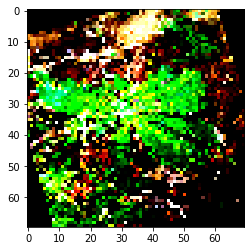

In [62]:
plt.imshow(  image[0].cpu().permute(1, 2 ,0))

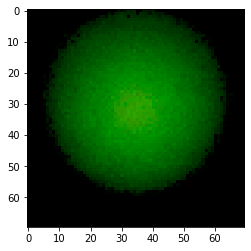

In [63]:
plt.imshow(reconstructed.cpu().permute(1, 2 ,0))

In [56]:
print(reconstructed.cpu().permute(1, 2 ,0).shape)

torch.Size([70, 70, 3])
